<a href="https://colab.research.google.com/github/mparvezrashid/ALDA/blob/master/GloVe_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import re
from bs4 import BeautifulSoup
from spacy.lang.en import English
import string
from spacy.lang.en.stop_words import STOP_WORDS
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from keras.preprocessing import sequence, text
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, BatchNormalization, Activation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras import metrics
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [4]:
df = pd.read_csv('C3_anonymized.csv', delimiter=',', usecols=['comment_text','constructive_binary'])

In [5]:

def text_clean(review):
    rv_text = BeautifulSoup(review, 'html.parser').get_text()
    rv_text = re.sub('[^a-zA-Z]', ' ', rv_text)
    rv_text = rv_text.strip()
    return rv_text

In [6]:
clean_comments = df.apply(lambda x: text_clean(x['comment_text']),axis=1)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://wikileaks.org/podesta-emails/emailid/7452#efmAAAAAv" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://youtu.be/AlT3NRQqm-4" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [9]:
tk = text.Tokenizer(num_words=20000)
tk.fit_on_texts(clean_comments.tolist())
X = tk.texts_to_sequences(clean_comments)
allX = sequence.pad_sequences(X, maxlen=150)
ally = LabelEncoder().fit_transform(df['constructive_binary'])
print(allX[1].size)

150


Class=1, n=6516 (54.300%)
Class=0, n=5484 (45.700%)


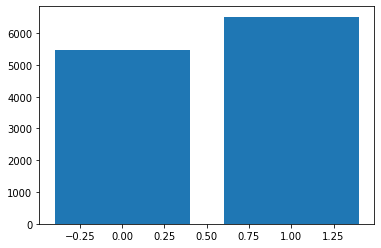

In [30]:

counter = Counter(ally)

for k,v in counter.items():
	per = v / len(ally) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.show()

Class=0, n=6000 (50.000%)
Class=1, n=6000 (50.000%)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


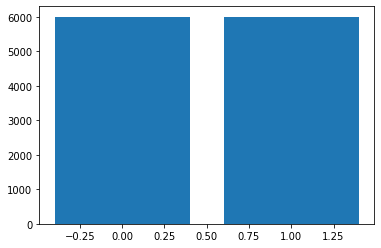

In [34]:


oversample = SMOTE(sampling_strategy={0:6000})
#oversample = SMOTE()
allX, ally = oversample.fit_resample(allX, ally)

under = RandomUnderSampler({1:6000})
allX, ally = under.fit_resample(allX, ally)
# summarize distribution
counter = Counter(ally)
#print(counter)
for k,v in counter.items():
	per = v / len(ally) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [10]:
word_index = tk.word_index
glv_embed_dict = {}
glv = open('glove.6B.300d.txt',encoding="utf8")
for line in glv:
    v = line.split()
    word = v[0]
    try:
        vector = np.asarray(v[1:], dtype='float32')
    except:
        pass
    glv_embed_dict[word] = vector
glv.close()

In [14]:
word_embd = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embed_vector = glv_embed_dict.get(word)
    if embed_vector is not None:
        word_embd[i] = embed_vector

print(word_embd[1].size)        

300


In [23]:
X_train, X_test, y_train, y_test = train_test_split(allX, ally,stratify=ally,test_size=0.25)

y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

'''X, X_test, y, y_test = train_test_split(allX, ally,stratify=ally,test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X, y,stratify=y,test_size=0.15)

y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)
y_val = LabelEncoder().fit_transform(y_val)'''



'X, X_test, y, y_test = train_test_split(allX, ally,stratify=ally,test_size=0.15)\nX_train, X_val, y_train, y_val = train_test_split(X, y,stratify=y,test_size=0.15)\n\ny_train = LabelEncoder().fit_transform(y_train)\ny_test = LabelEncoder().fit_transform(y_test)\ny_val = LabelEncoder().fit_transform(y_val)'

In [ ]:
bi_lstm = Sequential()
bi_lstm.add(Embedding(len(word_index) + 1,300,weights=[word_embd],input_length=150,trainable=True))
bi_lstm.add(Dropout(0.5))
bi_lstm.add(Bidirectional(LSTM(150,recurrent_dropout=0.5)))
bi_lstm.add(Dropout(0.5))
bi_lstm.add(Dense(1, activation='sigmoid'))
bi_lstm.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
bi_lstm_history = bi_lstm.fit(X_train, y_train, batch_size=64, epochs=20,
                            validation_split=0.1)

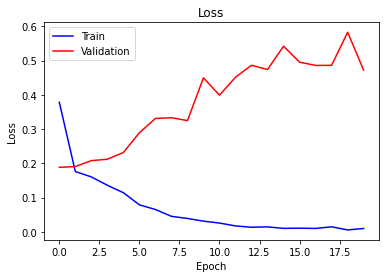

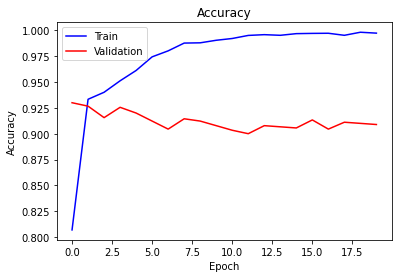

In [23]:
plot_history(bi_lstm_history)

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1371
           1       0.94      0.91      0.92      1629

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



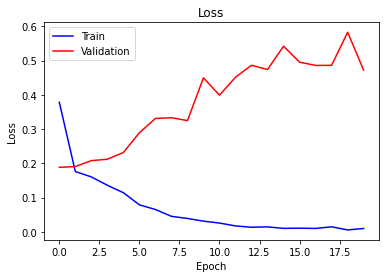

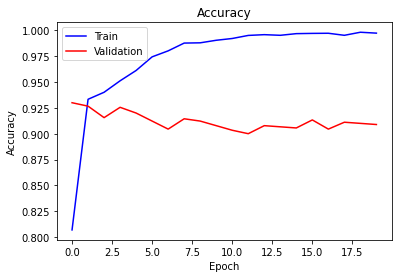

In [32]:
#bi_lstm_loss, bi_lstm_acc, bi_lstm_f1, bi_lstm_precision, bi_lstm_recall = bi_lstm.evaluate(X_test, y_test, batch_size=64)
#print('Test accuracy for BiLSTM+Glove Model is:', bi_lstm_acc)
y_pred_bi_lstm = bi_lstm.predict(X_test)
y_pred_bi_lstm = (y_pred_bi_lstm > 0.5)
print(classification_report(y_test, y_pred_bi_lstm))
plot_history(bi_lstm_history)

In [ ]:
bi_lstm = Sequential()
bi_lstm.add(Embedding(len(word_index) + 1,300,input_length=150,trainable=True))
bi_lstm.add(Dropout(0.5))
bi_lstm.add(Bidirectional(LSTM(150,recurrent_dropout=0.5)))
bi_lstm.add(Dropout(0.5))
bi_lstm.add(Dense(1, activation='sigmoid'))
bi_lstm.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
bi_lstm_history = bi_lstm.fit(X_train, y_train, batch_size=64, epochs=20,
                            validation_split=0.1)

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1371
           1       0.93      0.91      0.92      1629

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



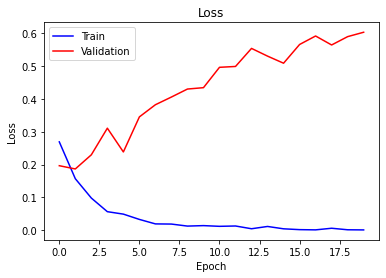

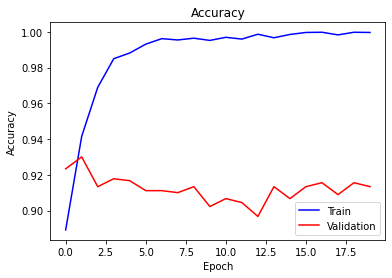

In [25]:
y_pred_bi_lstm = bi_lstm.predict(X_test)
y_pred_bi_lstm = (y_pred_bi_lstm > 0.5)
print(classification_report(y_test, y_pred_bi_lstm))
plot_history(bi_lstm_history)